# Credit Card Customer Churn Prediction

**Brief Summary**

- Applied linear (logistic regression) & non-linear model (SVC, 3 tree-based models) prediction.

- Data splitting with train (0.7) and test (0.3).

- Best performing model is LGBM classifier with tuned hyperparameter, the best score for testing data is 0.769 Macro-average f1 score.

# 1. Problem definition & Data Reading

- classification problem (prediction whether the customer stayed (0) or exited (1) the bank)
- given the related features (e.g. credit score, balance, number of products)

In [1]:
import os
import sys

import IPython
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from IPython.display import HTML, display
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import lognorm, loguniform, randint
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from IPython.display import Image
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
%matplotlib inline
pd.set_option("display.max_colwidth", 200)

In [2]:
df = pd.read_csv('data/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# Dropping unnecessary columns
df.drop(['RowNumber','CustomerId','Surname'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


# 2. Data splitting

In [4]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)


In [5]:
train_df.shape

(7000, 11)

# 3. EDA

## 3.1 Training data at a glance

In [6]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 3144 to 3582
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      7000 non-null   int64  
 1   Geography        7000 non-null   object 
 2   Gender           7000 non-null   object 
 3   Age              7000 non-null   int64  
 4   Tenure           7000 non-null   int64  
 5   Balance          7000 non-null   float64
 6   NumOfProducts    7000 non-null   int64  
 7   HasCrCard        7000 non-null   int64  
 8   IsActiveMember   7000 non-null   int64  
 9   EstimatedSalary  7000 non-null   float64
 10  Exited           7000 non-null   int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 656.2+ KB


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000
mean,650.144571,38.942571,5.020143,76448.489407,1.534429,0.705429,0.515286,99934.226306,0.204571
std,96.554892,10.612389,2.894639,62700.899244,0.582855,0.455882,0.499802,57555.469387,0.403417
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,583.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,50743.832500,0.000000
50%,652.000000,37.000000,5.000000,96889.925000,1.000000,1.000000,1.000000,99729.890000,0.000000
75%,717.000000,44.000000,8.000000,127838.535000,2.000000,1.000000,1.000000,149458.040000,0.000000
max,850.000000,92.000000,10.000000,238387.560000,4.000000,1.000000,1.000000,199992.480000,1.000000


## 3.2 Label Imbalance

In [7]:
train_df["Exited"].value_counts(normalize=True)


0    0.795429
1    0.204571
Name: Exited, dtype: float64

We have a class imbalance. Both classes seem importance here.

We will be going to use macro-average f1 score as our evaluation metric.

In [8]:
from sklearn.metrics import f1_score, make_scorer, recall_score

custom_scorer = make_scorer(f1_score, average="macro")
scoring_metric = custom_scorer

## 3.3 separating class label & features

In [9]:
X_train, y_train = (
    train_df.drop(columns=["Exited"]),
    train_df["Exited"],
)
X_test, y_test = (
    test_df.drop(columns=["Exited"]),
    test_df["Exited"],
)

## 3.4 Correlation Plot

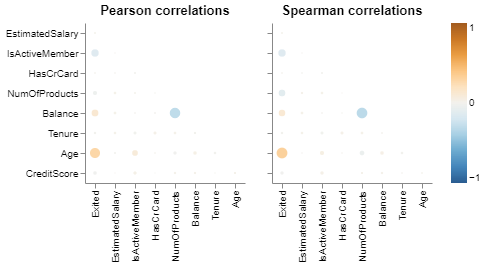

In [10]:
import altair_ally as aly
from altair_data_server import data_server

aly.alt.data_transformers.enable('data_server')
aly.alt.renderers.enable('mimetype')

aly.corr(train_df)

In [11]:
train_df.corr('spearman').style.background_gradient()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,0.006407,0.004991,0.012883,0.012178,0.000098,0.027965,-0.000284,-0.028045
Age,0.006407,1.000000,-0.015025,0.032517,-0.055963,0.004114,0.043716,-0.003896,0.318281
Tenure,0.004991,-0.015025,1.000000,-0.007421,0.017971,0.022227,-0.023151,0.014469,-0.013372
Balance,0.012883,0.032517,-0.007421,1.000000,-0.310379,-0.003376,-0.005624,0.016952,0.114544
NumOfProducts,0.012178,-0.055963,0.017971,-0.310379,1.000000,-0.002624,0.015832,0.012755,-0.117231
HasCrCard,0.000098,0.004114,0.022227,-0.003376,-0.002624,1.000000,-0.009708,-0.005103,0.006080
IsActiveMember,0.027965,0.043716,-0.023151,-0.005624,0.015832,-0.009708,1.000000,-0.003058,-0.146605
EstimatedSalary,-0.000284,-0.003896,0.014469,0.016952,0.012755,-0.005103,-0.003058,1.000000,0.008461
Exited,-0.028045,0.318281,-0.013372,0.114544,-0.117231,0.006080,-0.146605,0.008461,1.000000


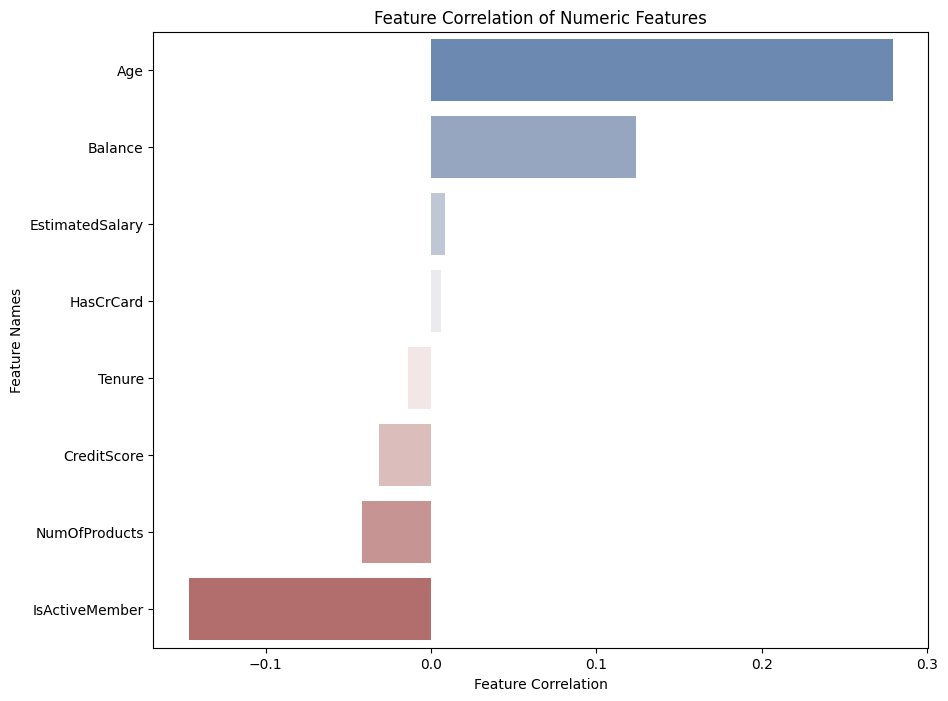

In [12]:
feat_corr = train_df.drop(columns='Exited').select_dtypes('number').apply(lambda x: x.corr(train_df.Exited))
feat_corr = pd.DataFrame(feat_corr, columns=['correlation']).sort_values(['correlation'], ascending=False)

# saving correlation heatmap
plt.figure(figsize=(10,8))
sns.barplot(x=feat_corr['correlation'], y=feat_corr.index, palette="vlag").set(
title="Feature Correlation of Numeric Features", xlabel="Feature Correlation",
ylabel="Feature Names")
plt.show()

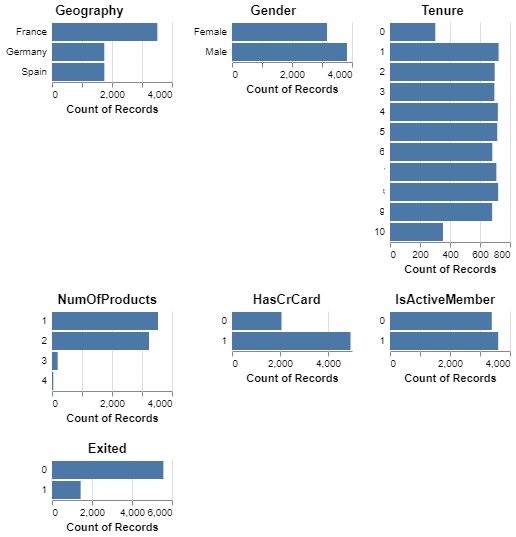

In [13]:
aly.dist(train_df[train_df.columns[train_df.nunique() <= 20]].astype('object'), dtype='object').resolve_scale(y='independent')


- We have very few features (only 10 features).

- We have class imbalance and we handle it by using balanced class in modeling. We selected to use macro average f1 as our scoring metric while assigning equal weight to the class (`Exited`).

- `Age` & `Exited` have the positive correlation, while `Balance` & `NumOfProducts` have the negative correlation.

- We have quite a few outliers in `NumOfProducts`.

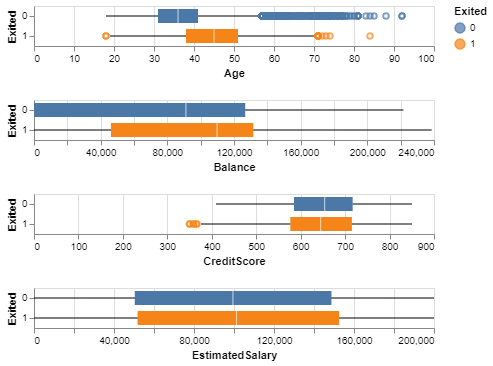

In [14]:
numeric_col = ['Age', 'Balance', 'CreditScore', 'EstimatedSalary']
  
numeric_boxplot = alt.Chart(train_df).mark_boxplot().encode(
    x=alt.X(alt.repeat(), type='quantitative'),
    y=alt.Y('Exited:N'),
    color='Exited:N'
).repeat(repeat=numeric_col, columns=1)


numeric_boxplot

- The feature ranges are very different (`Age`, `Balance`, `CreditScore`, `EstimatedSalary`), standardization is needed.

- `Age` shows different quantile value with quit a number of outliers in the staying customer class, and a few in the exiting customer class.

- The exited customer have higher mean `Balance` than the stayed customer.

- Both `CreditScore` and `EstimatedSalary` have similar quantile value in both classes (they are in different scale).

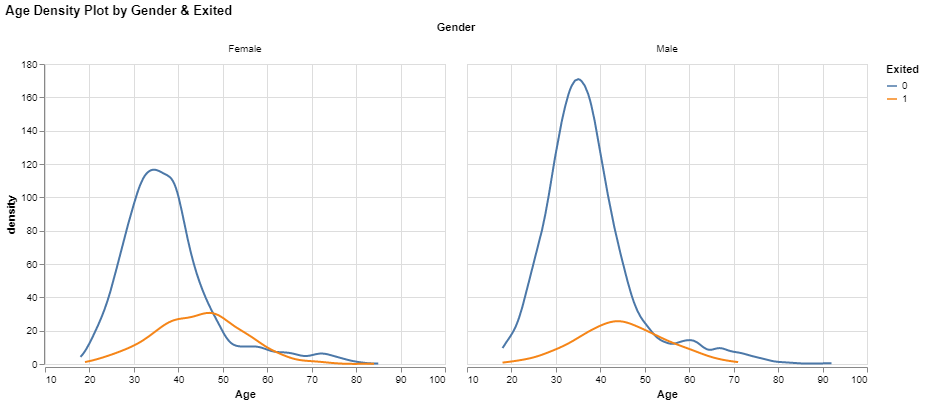

In [15]:
gender_density = (alt.Chart(train_df)
 .transform_density(
     'Age',
     groupby=['Exited','Gender'],
     as_=['Age', 'density'],
     counts=True,
 )
 .mark_line().encode(
     x='Age',
     y='density:Q',
     color='Exited:N',
 tooltip='Age')
 .facet('Gender',
       title="Age Density Plot by Gender & Exited"
       )
)

gender_density

- The age distribution of male & female is similar for both classes (stayed customer have lower age mean & exited customer have higher age mean)

# 4. Preprocessing and transformations

In [16]:
X_train, y_train = train_df.drop(columns=["Exited"]), train_df["Exited"]
X_test, y_test = test_df.drop(columns=["Exited"]), test_df["Exited"]


In [17]:
X_train.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

In [18]:
binary_features = ['Gender', 'HasCrCard', 'IsActiveMember']
categorical_features = ['Geography']
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary']
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_features),
    (OneHotEncoder(drop="if_binary", dtype=int), binary_features)
)
preprocessor.fit_transform(X_train, y_train)
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['CreditScore', 'Age', 'Tenure', 'Balance',
                                  'NumOfProducts', 'EstimatedSalary']),
                                ('onehotencoder-1',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['Geography']),
                                ('onehotencoder-2',
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'int'>),
                                 ['Gender', 'HasCrCard', 'IsActiveMember'])])

# 5. Define score comparison method

In [19]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

results = {}

# 6. Baseline model

In [20]:
dummy = DummyClassifier(strategy="stratified")
results["dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,dummy
fit_time,0.001 (+/- 0.001)
score_time,0.001 (+/- 0.001)
test_score,0.498 (+/- 0.012)
train_score,0.502 (+/- 0.009)


# 7. Linear models

- Try a linear model as a first real attempt.

- Carry out hyperparameter tuning to explore different values for the regularization hyperparameter.

## 7.1 Try Linear Model

In [21]:
pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=1000, class_weight="balanced")
)
results["logreg"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,dummy,logreg
fit_time,0.001 (+/- 0.001),0.022 (+/- 0.004)
score_time,0.001 (+/- 0.001),0.005 (+/- 0.001)
test_score,0.498 (+/- 0.012),0.644 (+/- 0.016)
train_score,0.502 (+/- 0.009),0.645 (+/- 0.004)


## 7.2 Hyperparameter for linear model (regularization)

In [22]:
param_grid = {"logisticregression__C": loguniform(1e-3, 1e3)}

random_search = RandomizedSearchCV(
    pipe_lr,
    param_grid,
    n_iter=50,
    verbose=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['CreditScore',
                                                                                'Age',
                                                                                'Tenure',
                                                                                'Balance',
                                                                                'NumOfProducts',
                                                                                'EstimatedSalary']),
                                                                              ('onehotencoder-1',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['Geography']),
                                                                              ('onehotencoder-2',
                                                                               OneHotEncoder(drop='if_binary',
                                                                                             dtype...
                                                                                'HasCrCard',
                                                                                'IsActiveMember'])])),
                                             ('logisticregression',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=1000))]),
                   n_iter=50,
                   param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002BB0CC77DF0>},
                   random_state=123, return_train_score=True,
                   scoring=make_scorer(f1_score, average=macro), verbose=1)

## 7.3 Report Regularized Linear Model Result

In [23]:
print("Best hyperparameter values: ", random_search.best_params_)
print("Best score: %0.3f" % (random_search.best_score_))

Best hyperparameter values:  {'logisticregression__C': 0.002280695888578118}
Best score: 0.649


In [24]:
# top 10 Search CV results
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_logisticregression__C",
        "mean_fit_time",
        "rank_test_score",
        "std_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

,mean_train_score,mean_test_score,param_logisticregression__C,mean_fit_time,std_test_score
rank_test_score,,,,,
1,0.651706,0.649367,0.002281,0.014384,0.010802
2,0.652323,0.648794,0.00357,0.014386,0.012660
3,0.652380,0.648169,0.00494,0.014783,0.011553
4,0.649824,0.648036,0.012444,0.015582,0.012876
5,0.650463,0.647633,0.01129,0.015396,0.012756
6,0.648069,0.647465,0.022967,0.017199,0.014078
7,0.647915,0.647342,0.02342,0.016389,0.014023
8,0.647340,0.646993,0.031822,0.016585,0.013645
9,0.646195,0.646210,0.080115,0.017383,0.014958


In [25]:
best_logreg = random_search.best_estimator_
results["logreg (tuned)"] = mean_std_cross_val_scores(
    best_logreg, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pd.DataFrame(results)

,dummy,logreg,logreg (tuned)
fit_time,0.001 (+/- 0.001),0.022 (+/- 0.004),0.015 (+/- 0.001)
score_time,0.001 (+/- 0.001),0.005 (+/- 0.001),0.004 (+/- 0.000)
test_score,0.498 (+/- 0.012),0.644 (+/- 0.016),0.649 (+/- 0.012)
train_score,0.502 (+/- 0.009),0.645 (+/- 0.004),0.652 (+/- 0.006)


- The results of the `logistic regression` are better than those of the `dummy classifier` (with or without best regularisation parameter).

- The validation scores were slightly improved by adjusting the regularisation hyperparameter of `logistic regression` (from 0.644 to 0.649).

- The gap between the train and validation scores is quite small, suggesting that we are underfitting. We can try other non-linear models to improve the score.

# 8. Different models

In [26]:
# ratio of 0 vs 1 (for non sklearn model)
import numpy as np

ratio = np.bincount(y_train)[0] / np.bincount(y_train)[1]
ratio

3.888268156424581

In [27]:
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

models = {
    "RBF SVM": SVC(),
    "random forest": RandomForestClassifier(class_weight="balanced", random_state=2),
    "xgboost": XGBClassifier(scale_pos_weight=ratio, random_state=2),
    "lgbm": LGBMClassifier(scale_pos_weight=ratio, random_state=2),
}

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results[name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.001),0.001 (+/- 0.001),0.498 (+/- 0.012),0.502 (+/- 0.009)
logreg,0.022 (+/- 0.004),0.005 (+/- 0.001),0.644 (+/- 0.016),0.645 (+/- 0.004)
logreg (tuned),0.015 (+/- 0.001),0.004 (+/- 0.000),0.649 (+/- 0.012),0.652 (+/- 0.006)
RBF SVM,0.315 (+/- 0.007),0.144 (+/- 0.007),0.718 (+/- 0.024),0.736 (+/- 0.012)
random forest,0.359 (+/- 0.003),0.021 (+/- 0.001),0.733 (+/- 0.030),1.000 (+/- 0.000)
xgboost,0.157 (+/- 0.003),0.008 (+/- 0.001),0.728 (+/- 0.018),0.958 (+/- 0.005)
lgbm,0.059 (+/- 0.004),0.006 (+/- 0.001),0.738 (+/- 0.013),0.882 (+/- 0.005)


- We are using four non-linear models here: `RBF SVM` and three `tree-based models`.

- All models are set with default hyperparameters.

- Similar to `logistic regression`, `SVC` also seems to underfit; the gap between train and test scores are not large. Also, as expected, `SVC` takes longer to fit compared to other models. We will ignore using this model in further stage.

- `LGBM` seems to be the best performing model among the tree-based models. It also seems to be much faster and overfitting less compared to `random forest` and `xgboost`.

In [28]:
# ignoring SVM
del models["RBF SVM"]

# 9. Feature selection

## 9.1 Applying logistic regression for feature selection

In [29]:
from sklearn.feature_selection import SelectFromModel

for name, model in models.items():
    pipe = make_pipeline(
        preprocessor,
        SelectFromModel(
            LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
        ),
        model,
    )
    results[name + "+ feat_sel"] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

In [30]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.001),0.001 (+/- 0.001),0.498 (+/- 0.012),0.502 (+/- 0.009)
logreg,0.022 (+/- 0.004),0.005 (+/- 0.001),0.644 (+/- 0.016),0.645 (+/- 0.004)
logreg (tuned),0.015 (+/- 0.001),0.004 (+/- 0.000),0.649 (+/- 0.012),0.652 (+/- 0.006)
RBF SVM,0.315 (+/- 0.007),0.144 (+/- 0.007),0.718 (+/- 0.024),0.736 (+/- 0.012)
random forest,0.359 (+/- 0.003),0.021 (+/- 0.001),0.733 (+/- 0.030),1.000 (+/- 0.000)
xgboost,0.157 (+/- 0.003),0.008 (+/- 0.001),0.728 (+/- 0.018),0.958 (+/- 0.005)
lgbm,0.059 (+/- 0.004),0.006 (+/- 0.001),0.738 (+/- 0.013),0.882 (+/- 0.005)
random forest+ feat_sel,0.378 (+/- 0.014),0.022 (+/- 0.001),0.733 (+/- 0.032),1.000 (+/- 0.000)
xgboost+ feat_sel,0.163 (+/- 0.002),0.008 (+/- 0.001),0.728 (+/- 0.018),0.958 (+/- 0.005)
lgbm+ feat_sel,0.068 (+/- 0.004),0.006 (+/- 0.001),0.739 (+/- 0.014),0.881 (+/- 0.005)


## 9.2 Counting the number of selected features

In [31]:
pipe_random_forest = make_pipeline(
    preprocessor,
    SelectFromModel(
        LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
    ),
    models["random forest"],
)

pipe_random_forest.fit(X_train, y_train)
print(
    "Number of features selected: ",
    pipe_random_forest.named_steps["randomforestclassifier"].n_features_in_,
)

Number of features selected:  11


- L2 regularisation identified a total of 11 features.

- With logistic regression and L2 regularisation, the results show very slight improvements. but not much.

- Additionally, we do not have a lot of features. So let's disregard feature selection from the pipeline.

# 10. Hyperparameter optimization

## 10.1 Random forest hyperparameter optimization 


In [32]:
param_grid_rf = {
    "randomforestclassifier__n_estimators": randint(low=10, high=100),
    "randomforestclassifier__max_depth": randint(low=2, high=20),
}

pipe_random_forest = make_pipeline(preprocessor, models["random forest"])


In [33]:
random_search_rf = RandomizedSearchCV(
    pipe_random_forest,
    param_grid_rf,
    n_iter=50,
    verbose=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['CreditScore',
                                                                                'Age',
                                                                                'Tenure',
                                                                                'Balance',
                                                                                'NumOfProducts',
                                                                                'EstimatedSalary']),
                                                                              ('onehotencoder-1',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['Geography']),
                                                                              ('onehotencoder-2',
                                                                               OneHotEncoder(drop='if_binary',
                                                                                             dtype...
                   param_distributions={'randomforestclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002BB0FB32BF0>,
                                        'randomforestclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002BB0FB63550>},
                   random_state=123, return_train_score=True,
                   scoring=make_scorer(f1_score, average=macro), verbose=1)

In [34]:
print("Best hyperparameter values: ", random_search_rf.best_params_)
print("Best score: %0.3f" % (random_search_rf.best_score_))

Best hyperparameter values:  {'randomforestclassifier__max_depth': 11, 'randomforestclassifier__n_estimators': 62}
Best score: 0.752


In [35]:
pd.DataFrame(random_search_rf.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_randomforestclassifier__n_estimators",
        "param_randomforestclassifier__max_depth",
        "mean_fit_time",
        "rank_test_score",
        "std_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

,mean_train_score,mean_test_score,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,mean_fit_time,std_test_score
rank_test_score,,,,,,
1,0.921448,0.752303,62,11,0.192017,0.020466
2,0.880309,0.751038,35,10,0.106998,0.015715
3,0.845447,0.749211,76,9,0.207799,0.017089
4,0.918970,0.748775,42,11,0.131800,0.019571
5,0.974855,0.747168,68,13,0.248603,0.026356
6,0.954433,0.747135,79,12,0.256402,0.025203
7,0.954273,0.746674,67,12,0.217201,0.023365
8,0.811863,0.746554,95,8,0.241769,0.012936
9,0.973827,0.744432,37,13,0.126401,0.021553


In [36]:
best_rf_model = random_search_rf.best_estimator_
results["random forest (tuned)"] = mean_std_cross_val_scores(
    best_rf_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.001),0.001 (+/- 0.001),0.498 (+/- 0.012),0.502 (+/- 0.009)
logreg,0.022 (+/- 0.004),0.005 (+/- 0.001),0.644 (+/- 0.016),0.645 (+/- 0.004)
logreg (tuned),0.015 (+/- 0.001),0.004 (+/- 0.000),0.649 (+/- 0.012),0.652 (+/- 0.006)
RBF SVM,0.315 (+/- 0.007),0.144 (+/- 0.007),0.718 (+/- 0.024),0.736 (+/- 0.012)
random forest,0.359 (+/- 0.003),0.021 (+/- 0.001),0.733 (+/- 0.030),1.000 (+/- 0.000)
xgboost,0.157 (+/- 0.003),0.008 (+/- 0.001),0.728 (+/- 0.018),0.958 (+/- 0.005)
lgbm,0.059 (+/- 0.004),0.006 (+/- 0.001),0.738 (+/- 0.013),0.882 (+/- 0.005)
random forest+ feat_sel,0.378 (+/- 0.014),0.022 (+/- 0.001),0.733 (+/- 0.032),1.000 (+/- 0.000)
xgboost+ feat_sel,0.163 (+/- 0.002),0.008 (+/- 0.001),0.728 (+/- 0.018),0.958 (+/- 0.005)
lgbm+ feat_sel,0.068 (+/- 0.004),0.006 (+/- 0.001),0.739 (+/- 0.014),0.881 (+/- 0.005)


## 10.2 XGBoost hyperparameter optimization

In [37]:
param_grid_xgboost = {
    "xgbclassifier__n_estimators": randint(10, 100),
    "xgbclassifier__max_depth": randint(low=2, high=20),
    "xgbclassifier__learning_rate": [0.01, 0.1],
    "xgbclassifier__subsample": [0.5, 0.75, 1],
}

pipe_xgboost = make_pipeline(
    preprocessor,
    models["xgboost"],
)

In [38]:
random_search_xgboost = RandomizedSearchCV(
    pipe_xgboost,
    param_grid_xgboost,
    n_iter=50,
    verbose=1,
    n_jobs=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search_xgboost.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['CreditScore',
                                                                                'Age',
                                                                                'Tenure',
                                                                                'Balance',
                                                                                'NumOfProducts',
                                                                                'EstimatedSalary']),
                                                                              ('onehotencoder-1',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['Geography']),
                                                                              ('onehotencoder-2',
                                                                               OneHotEncoder(drop='if_binary',
                                                                                             dtype...
                                        'xgbclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002BB0FBB1FF0>,
                                        'xgbclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002BB0FBB3D30>,
                                        'xgbclassifier__subsample': [0.5, 0.75,
                                                                     1]},
                   random_state=123, return_train_score=True,
                   scoring=make_scorer(f1_score, average=macro), verbose=1)

In [39]:
print("Best hyperparameter values: ", random_search_xgboost.best_params_)
print("Best score: %0.3f" % (random_search_xgboost.best_score_))


Best hyperparameter values:  {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 10, 'xgbclassifier__n_estimators': 84, 'xgbclassifier__subsample': 0.5}
Best score: 0.748


In [40]:

pd.DataFrame(random_search_xgboost.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_xgbclassifier__n_estimators",
        "param_xgbclassifier__learning_rate",
        "param_xgbclassifier__subsample",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

,mean_train_score,mean_test_score,param_xgbclassifier__n_estimators,param_xgbclassifier__learning_rate,param_xgbclassifier__subsample,mean_fit_time
rank_test_score,,,,,,
1,0.871378,0.747983,84,0.01,0.5,0.221399
2,0.946901,0.745714,35,0.1,0.75,0.127201
3,0.955907,0.745540,97,0.01,0.75,0.409201
4,0.933118,0.745471,95,0.1,1,0.216800
5,0.935643,0.745265,75,0.01,0.75,0.297801
6,0.908032,0.744480,76,0.01,0.5,0.225600
7,0.911683,0.743693,87,0.01,0.5,0.295401
8,0.897157,0.743266,50,0.01,0.5,0.173201
9,0.999726,0.743113,96,0.1,0.75,0.384600


In [41]:
best_xgboost_model = random_search_xgboost.best_estimator_
results["xgboost (tuned)"] = mean_std_cross_val_scores(
    best_xgboost_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.001),0.001 (+/- 0.001),0.498 (+/- 0.012),0.502 (+/- 0.009)
logreg,0.022 (+/- 0.004),0.005 (+/- 0.001),0.644 (+/- 0.016),0.645 (+/- 0.004)
logreg (tuned),0.015 (+/- 0.001),0.004 (+/- 0.000),0.649 (+/- 0.012),0.652 (+/- 0.006)
RBF SVM,0.315 (+/- 0.007),0.144 (+/- 0.007),0.718 (+/- 0.024),0.736 (+/- 0.012)
random forest,0.359 (+/- 0.003),0.021 (+/- 0.001),0.733 (+/- 0.030),1.000 (+/- 0.000)
xgboost,0.157 (+/- 0.003),0.008 (+/- 0.001),0.728 (+/- 0.018),0.958 (+/- 0.005)
lgbm,0.059 (+/- 0.004),0.006 (+/- 0.001),0.738 (+/- 0.013),0.882 (+/- 0.005)
random forest+ feat_sel,0.378 (+/- 0.014),0.022 (+/- 0.001),0.733 (+/- 0.032),1.000 (+/- 0.000)
xgboost+ feat_sel,0.163 (+/- 0.002),0.008 (+/- 0.001),0.728 (+/- 0.018),0.958 (+/- 0.005)
lgbm+ feat_sel,0.068 (+/- 0.004),0.006 (+/- 0.001),0.739 (+/- 0.014),0.881 (+/- 0.005)


## 10.3 LGBM hyperparameter optimization

In [42]:
param_grid_lgbm = {
    "lgbmclassifier__n_estimators": randint(10, 100),
    "lgbmclassifier__max_depth": randint(low=2, high=20),
    "lgbmclassifier__learning_rate": [0.01, 0.1],
    "lgbmclassifier__subsample": [0.5, 0.75, 1],
}

pipe_lgbm = make_pipeline(
    preprocessor,
    models["lgbm"],
)

In [43]:
random_search_lgbm = RandomizedSearchCV(
    pipe_lgbm,
    param_grid_lgbm,
    n_iter=50,
    verbose=1,
    n_jobs=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['CreditScore',
                                                                                'Age',
                                                                                'Tenure',
                                                                                'Balance',
                                                                                'NumOfProducts',
                                                                                'EstimatedSalary']),
                                                                              ('onehotencoder-1',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['Geography']),
                                                                              ('onehotencoder-2',
                                                                               OneHotEncoder(drop='if_binary',
                                                                                             dtype...
                                        'lgbmclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002BB0FBE4790>,
                                        'lgbmclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002BB05E6D8A0>,
                                        'lgbmclassifier__subsample': [0.5, 0.75,
                                                                      1]},
                   random_state=123, return_train_score=True,
                   scoring=make_scorer(f1_score, average=macro), verbose=1)

In [44]:
print("Best hyperparameter values: ", random_search_lgbm.best_params_)
print("Best score: %0.3f" % (random_search_lgbm.best_score_))

Best hyperparameter values:  {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 5, 'lgbmclassifier__n_estimators': 12, 'lgbmclassifier__subsample': 0.5}
Best score: 0.755


In [45]:
pd.DataFrame(random_search_lgbm.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_lgbmclassifier__n_estimators",
        "param_lgbmclassifier__learning_rate",
        "param_lgbmclassifier__subsample",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

,mean_train_score,mean_test_score,param_lgbmclassifier__n_estimators,param_lgbmclassifier__learning_rate,param_lgbmclassifier__subsample,mean_fit_time
rank_test_score,,,,,,
1,0.766897,0.755066,12,0.1,0.5,0.020201
2,0.775696,0.754543,97,0.01,0.75,0.074201
3,0.767112,0.753219,87,0.01,0.5,0.067600
4,0.776134,0.752798,96,0.01,1,0.068400
5,0.782672,0.750501,12,0.1,1,0.020800
6,0.765521,0.749364,85,0.01,1,0.068201
7,0.764980,0.748799,84,0.01,0.5,0.071201
8,0.782981,0.744958,13,0.1,0.5,0.023801
9,0.752627,0.742268,75,0.01,1,0.056600


In [46]:
best_lgbm_model = random_search_lgbm.best_estimator_
results["lgbm (tuned)"] = mean_std_cross_val_scores(
    best_lgbm_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.001),0.001 (+/- 0.001),0.498 (+/- 0.012),0.502 (+/- 0.009)
logreg,0.022 (+/- 0.004),0.005 (+/- 0.001),0.644 (+/- 0.016),0.645 (+/- 0.004)
logreg (tuned),0.015 (+/- 0.001),0.004 (+/- 0.000),0.649 (+/- 0.012),0.652 (+/- 0.006)
RBF SVM,0.315 (+/- 0.007),0.144 (+/- 0.007),0.718 (+/- 0.024),0.736 (+/- 0.012)
random forest,0.359 (+/- 0.003),0.021 (+/- 0.001),0.733 (+/- 0.030),1.000 (+/- 0.000)
xgboost,0.157 (+/- 0.003),0.008 (+/- 0.001),0.728 (+/- 0.018),0.958 (+/- 0.005)
lgbm,0.059 (+/- 0.004),0.006 (+/- 0.001),0.738 (+/- 0.013),0.882 (+/- 0.005)
random forest+ feat_sel,0.378 (+/- 0.014),0.022 (+/- 0.001),0.733 (+/- 0.032),1.000 (+/- 0.000)
xgboost+ feat_sel,0.163 (+/- 0.002),0.008 (+/- 0.001),0.728 (+/- 0.018),0.958 (+/- 0.005)
lgbm+ feat_sel,0.068 (+/- 0.004),0.006 (+/- 0.001),0.739 (+/- 0.014),0.881 (+/- 0.005)


Hyperparameter optimization seems to help with `random forests` as well as `LightGBM`. The scores for both models seem very similar. But we pick `LightGBM` because

- it seems to be less overfitting

- it's much faster

- the standard deviation is smaller compared to random forest.

# 11. Interpretation and feature importances

In [47]:
import eli5

categorical_OHE = list(
    best_lgbm_model.named_steps["columntransformer"]
    .named_transformers_["onehotencoder-1"]
    .get_feature_names(categorical_features)
)

feature_names = numeric_features +  categorical_OHE + binary_features

eli5.show_weights(
    best_lgbm_model.named_steps["lgbmclassifier"],
    feature_names=feature_names,
)

C:\Users\caesa_mt2kv9g\.conda\envs\573\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight,Feature
0.4457,Age
0.3028,NumOfProducts
0.1021,Balance
0.0728,IsActiveMember
0.0473,Geography_Germany
0.0143,Gender
0.0073,EstimatedSalary
0.0025,CreditScore
0.0025,Geography_France
0.0017,Tenure


In [48]:
import shap

preprocessor.fit(X_train, y_train)

X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

X_train_enc.head()

C:\Users\caesa_mt2kv9g\.conda\envs\573\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender,HasCrCard,IsActiveMember
3144,-0.022212,1.513191,-1.388923,0.078499,-0.916980,1.417861,0.0,0.0,1.0,1.0,0.0,1.0
9939,0.443877,1.701664,1.375004,-1.219344,0.798834,0.618031,0.0,0.0,1.0,0.0,1.0,1.0
7925,-0.664380,-0.560005,0.684023,-1.219344,0.798834,1.187238,0.0,0.0,1.0,0.0,1.0,1.0
309,-2.197296,-0.748478,1.029514,0.031105,-0.916980,-0.955620,0.0,1.0,0.0,1.0,1.0,0.0
9415,1.220693,0.382357,-1.043432,0.842402,0.798834,-1.403687,0.0,1.0,0.0,0.0,0.0,0.0


In [49]:
lgbm_tuned = LGBMClassifier(
    scale_pos_weight=ratio,
    random_state=2,
    learning_rate=random_search_lgbm.best_params_["lgbmclassifier__learning_rate"],
    n_estimators=random_search_lgbm.best_params_["lgbmclassifier__n_estimators"],
    subsample=random_search_lgbm.best_params_["lgbmclassifier__subsample"],
)

lgbm_tuned.fit(X_train_enc, y_train)
lgbm_explainer = shap.TreeExplainer(lgbm_tuned)
lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [50]:
values = np.abs(lgbm_shap_values[0]).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]

,SHAP
Age,0.511856
NumOfProducts,0.477049
IsActiveMember,0.203808
Balance,0.153526
Geography_Germany,0.096675
Gender,0.089112
EstimatedSalary,0.023534
CreditScore,0.015519
Tenure,0.008921
Geography_France,0.008396


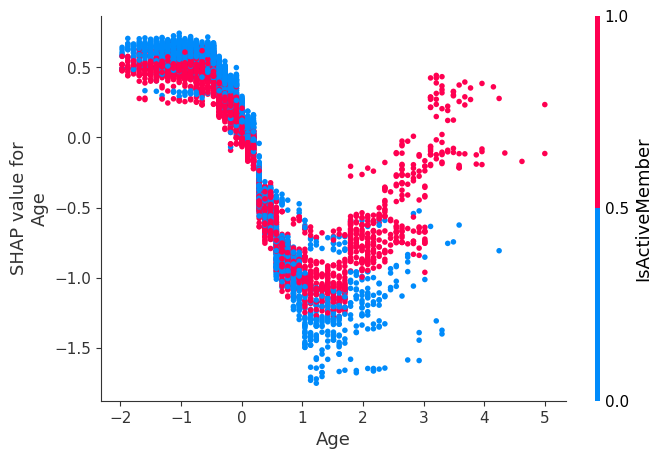

In [51]:
shap.dependence_plot("Age", lgbm_shap_values[0], X_train_enc)

As `Age` increases, SHAP values for class 0 drop at first, suggesting that class is likely to be 1 (exited) with mean values for `Age`.

When `Age` increases until the maximum in the dataset, the SHAP values for class 0 increases, suggesting that class is likely to be 0 (stayed).

The above dependencies plot and SHAP values make sense as younger customer will stay with the bank when they first join. Middle aged customer will be more likely to exit the bank as they might have more options (e.g. promotion, investment plan, etc.). The oldest customer will stay with the bank as they prefer less changes to their financial decision.

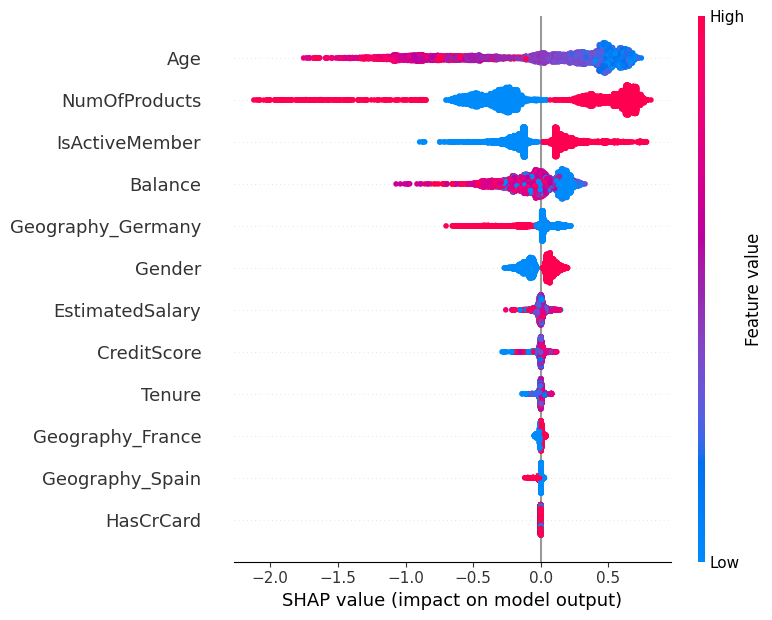

In [52]:
shap.summary_plot(lgbm_shap_values[0], X_train_enc)


In [53]:
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [54]:
lgbm_tuned.predict_proba(X_test_enc)[1]

array([0.76228674, 0.23771326])

In [55]:
lgbm_tuned.predict(X_test_enc, raw_score=True)[1]

-1.1652576352067328

In [56]:
lgbm_explainer.expected_value

[0.8472106048073239, -0.8472106048073239]

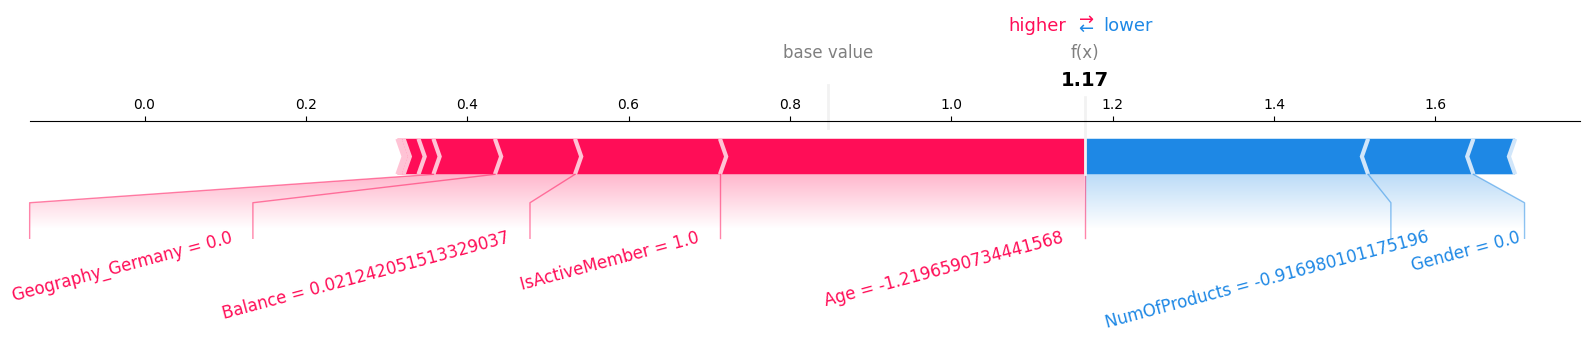

In [57]:
shap.force_plot(
    lgbm_explainer.expected_value[0],
    test_lgbm_shap_values[0][1, :],
    X_test_enc.iloc[1, :],
    matplotlib=True,
    text_rotation=15
)

From the analysis above we observe that `Age`, `NumOfProducts`, `IsActiveMember` features seem to be one of the most important features with `Age` being the topmost feature.

The SHAP dependence plot demonstrates that the class is likely to be 0 (stay) for extreme `Age` values, which makes sense.

# 12. Results on the test set

In [58]:
from sklearn.metrics import f1_score

best_model = random_search_lgbm.best_estimator_
print(
    "Grid Search best model validation score: %0.3f" % (random_search_lgbm.best_score_)
)

predictions = best_model.predict(X_test)
print(
    "Macro-average f1 score on the test set: %0.3f"
    % (f1_score(y_test, predictions, average="macro"))
)

Grid Search best model validation score: 0.755
Macro-average f1 score on the test set: 0.769


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


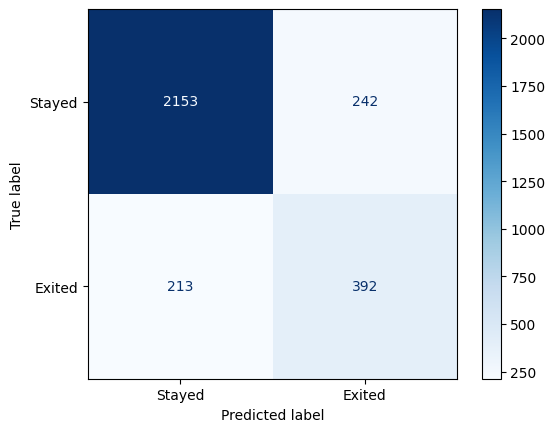

In [59]:
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(
    best_model,
    X_test,
    y_test,
    display_labels=["Stayed", "Exited"],
    values_format="d",
    cmap=plt.cm.Blues,
)

In [60]:
print(
    classification_report(
        y_test, predictions, target_names=["Stayed", "Exited"]
    )
)

              precision    recall  f1-score   support

      Stayed       0.91      0.90      0.90      2395
      Exited       0.62      0.65      0.63       605

    accuracy                           0.85      3000
   macro avg       0.76      0.77      0.77      3000
weighted avg       0.85      0.85      0.85      3000



The held-out test set's macro-average f1-score (0.769) is roughly in line with the validation score's macro-average f1-score (0.755). There doesn't appear to be much optimization bias in this situation.


In [61]:
# get indices of stayed, exited customer
y_test_reset = y_test.reset_index(drop=True)
stay_ind = y_test_reset[y_test_reset == 0].index.tolist()
exit_ind = y_test_reset[y_test_reset == 1].index.tolist()

ex_stay_index = stay_ind[0]
ex_exit_index = exit_ind[0]

**Explanation of a stayed customer prediction**

In [62]:
lgbm_tuned.predict_proba(X_test_enc)[ex_stay_index]

array([0.90221223, 0.09778777])

In [63]:
lgbm_tuned.predict(X_test_enc, raw_score=True)[ex_stay_index]

-2.2220502164727476

In [64]:
lgbm_explainer.expected_value

[0.8472106048073239, -0.8472106048073239]

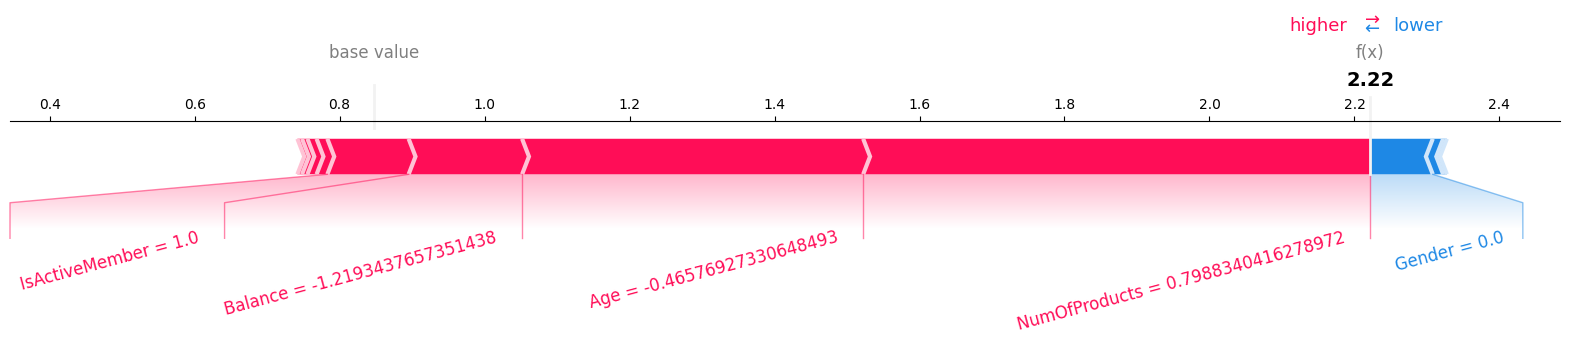

In [65]:
shap.force_plot(
    lgbm_explainer.expected_value[0],
    test_lgbm_shap_values[0][ex_stay_index, :],
    X_test_enc.iloc[ex_stay_index, :],
    matplotlib=True,
    text_rotation=15
)

The raw model score is 2.22, which is greater than the base value 0.847 and so the prediction is that the user is not likely to exit the bank (because we are consider the SHAP values for class 0).

**Explanation of an exited customer prediction**

In [66]:
lgbm_tuned.predict_proba(X_test_enc)[ex_exit_index]

array([0.63653451, 0.36346549])

In [67]:
lgbm_tuned.predict(X_test_enc, raw_score=True)[ex_exit_index]

-0.5603542788905044

In [68]:
lgbm_explainer.expected_value

[0.8472106048073239, -0.8472106048073239]

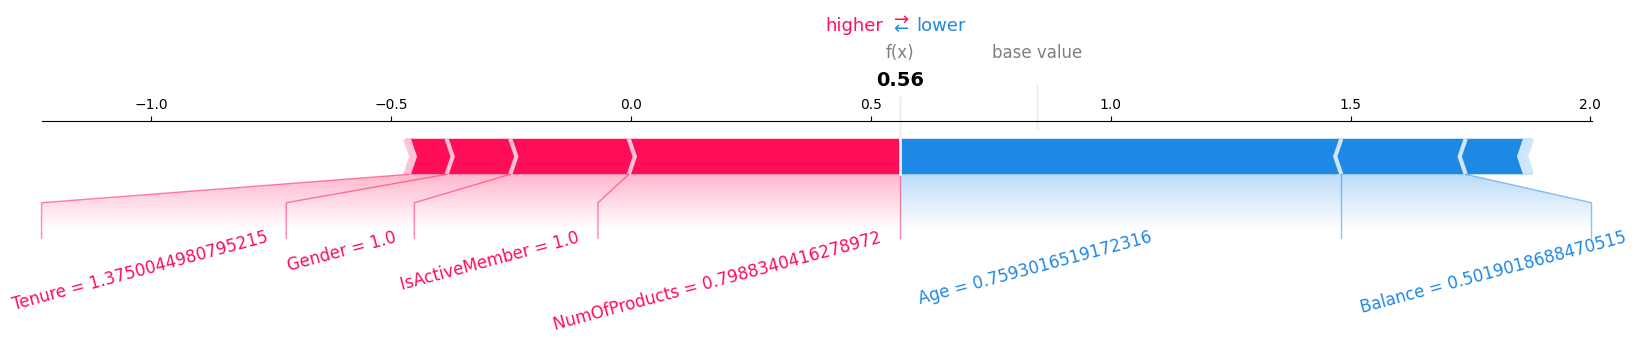

In [69]:
shap.force_plot(
    lgbm_explainer.expected_value[0],
    test_lgbm_shap_values[0][ex_exit_index, :],
    X_test_enc.iloc[ex_exit_index, :],
    matplotlib=True,
    text_rotation=15
)

- The raw model score is 0.56, which is smaller than the base value 0.847 and so the prediction is that the user is likely to exit the bank (class 1).

- Positive values for `Balance` variables seem to push the prediction towards a lower value.

# 13. Summary of results

In [70]:
summary_df = pd.DataFrame(results).T

In [71]:
comments = {
    "dummy": "Baseline of 0.50 macro-average f1 score.",
    "logreg": "Improvement over the baseline but underfitting.",
    "logreg (tuned)": "Slight improvement but still underfitting.",
    "RBF SVM": "Improvement over tuned logistic regression but slow.",
    "random forest": "Improvement over tuned logistic regression but overfitting.",
    "xgboost": "Less overfitting compared to random forest.",
    "lgbm": "Improvement over xgboost & random forest, and less overfitting.",
    "random forest+ feat_sel": "Feature selection with L1 regularization helps a tiny bit. Selects 11 features.",
    "xgboost+ feat_sel": "Very tiny improvement with L1 feature selection.",
    "lgbm+ feat_sel": "Very tiny improvement with L1 feature selection.",
    "random forest (tuned)": "Hyperparameter optimization helped. Best results so far.",
    "xgboost (tuned)": "Improvement over default XGBoost.",
    "lgbm (tuned)": "Hyperparameter optimization helped. Best results overall. The scores are very similar to random forest scores but picking this as the best model for its speed and less overfitting",
}
pd.set_option("display.max_colwidth", 0)
summary_df["comments"] = comments.values()
summary_df

,fit_time,score_time,test_score,train_score,comments
dummy,0.001 (+/- 0.001),0.001 (+/- 0.001),0.498 (+/- 0.012),0.502 (+/- 0.009),Baseline of 0.50 macro-average f1 score.
logreg,0.022 (+/- 0.004),0.005 (+/- 0.001),0.644 (+/- 0.016),0.645 (+/- 0.004),Improvement over the baseline but underfitting.
logreg (tuned),0.015 (+/- 0.001),0.004 (+/- 0.000),0.649 (+/- 0.012),0.652 (+/- 0.006),Slight improvement but still underfitting.
RBF SVM,0.315 (+/- 0.007),0.144 (+/- 0.007),0.718 (+/- 0.024),0.736 (+/- 0.012),Improvement over tuned logistic regression but slow.
random forest,0.359 (+/- 0.003),0.021 (+/- 0.001),0.733 (+/- 0.030),1.000 (+/- 0.000),Improvement over tuned logistic regression but overfitting.
xgboost,0.157 (+/- 0.003),0.008 (+/- 0.001),0.728 (+/- 0.018),0.958 (+/- 0.005),Less overfitting compared to random forest.
lgbm,0.059 (+/- 0.004),0.006 (+/- 0.001),0.738 (+/- 0.013),0.882 (+/- 0.005),"Improvement over xgboost & random forest, and less overfitting."
random forest+ feat_sel,0.378 (+/- 0.014),0.022 (+/- 0.001),0.733 (+/- 0.032),1.000 (+/- 0.000),Feature selection with L1 regularization helps a tiny bit. Selects 11 features.
xgboost+ feat_sel,0.163 (+/- 0.002),0.008 (+/- 0.001),0.728 (+/- 0.018),0.958 (+/- 0.005),Very tiny improvement with L1 feature selection.
lgbm+ feat_sel,0.068 (+/- 0.004),0.006 (+/- 0.001),0.739 (+/- 0.014),0.881 (+/- 0.005),Very tiny improvement with L1 feature selection.


**Concluding remarks**

All our models outperformed the baseline. Our best model was LightGBM classifier with tuned hyperparameters. It obtained a 0.755 cross-validation macro-average f1 score. The scores do not appear to overfit much; there isn't a significant difference between the mean train score (0.767) and mean cross-validation score (0.755). These scores are very similar to the tuned random forest (CV score: 0.752). But random forest seems to overfit (train score: 0.921). It is also considerably slower than LightGBM. we decided to use the LightGBM model as our final model.

On the held out test set, we observed the macro-average f1 score of 0.769 using this model, which is consistent with the mean cross-validation macro-average f1-score (0.755). There doesn't appear to be much optimization bias in this situation.

We observed that L1 feature selection helped a tiny bit for all the tree-based models. In general, we have small number of features in this problem and feature selection doesn't seem crucial.

Our analysis of feature importance shows that our `Age`, `NumOfProducts`, `IsActiveMember` variables seems to be most important features.
